In [1]:
import pandas as pd
import os
from matplotlib import pylab as plt
import numpy as np
from pyteomics import mzml, fasta, parser
from matplotlib.collections import PatchCollection
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import warnings

from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
from  sklearn.decomposition import PCA
from umap.umap_ import UMAP
from collections import defaultdict

## load and save data from Spectronaut results

### IDs

In [2]:
def get_spectronaut_res_TEhPSC(work_dir, label):
    out = []
    indexes = []
    for f in os.listdir(work_dir):
        data = {}
        df = pd.read_table(os.path.join(work_dir, f))
        df.index = df["Parameter"]
        df = df["Value"].to_dict()
        data["file"] = f.split(".")[0]
        data["index"] = "_".join(f.split(".")[0].split("_")[-2:])
        data[label] = 0 if df['Protein Groups'].split(" of")[0].replace("\xa0", "")=="NA" else int(df['Protein Groups'].split(" of")[0].replace("\xa0", "")) 
        out.append(pd.Series(data))
    oout = pd.concat(out, axis=1).T
    oout.index = oout["index"]
    return  oout

In [3]:
root = "/groups/protechhub/user/JuliaBubis/article/SN18/TE_hPSC/"

dirs = ["20240207_125119_JB_hPSC_TE_blanks_240k_20Th_40ms_50SPD_noMBR/RunSummaries/",
        "20240207_125207_JB_hPSC_TE_blanks_240k_20Th_40ms_50SPD_MBR/RunSummaries/",
        "20240207_125439_JB_hPSC_TE_blanks_240k_20Th_40ms_50SPD_LibrartyCombined/RunSummaries/",
        "20240207_131413_JB_hPSC_TE_SC_240k_20Th_40ms_50SPD_noMBR/RunSummaries/",
        "20240207_131636_JB_hPSC_SC_240k_20Th_40ms_50SPD_MBR/RunSummaries/",
        "20240207_131720_JB_TE_SC_240k_20Th_40ms_50SPD_MBR/RunSummaries/",
        "20240207_132111_JB_TE_240k_20Th_40ms_50SPD_L100SC/RunSummaries/",
        "20240207_132212_JB_hPSC_240k_20Th_40ms_50SPD_L100SC/RunSummaries/",
       ]

In [4]:
labels = ["Method Evaluation", 
          "DirectDIA+", 
          "Library Search (100 cells)", 
          "Method Evaluation",  
          "DirectDIA+", "DirectDIA+",  
          "Library Search (100 cells)", 
          "Library Search (100 cells)",]
cdir = dirs[1]
data = []
for cdir, xlabel in zip(dirs, labels):
    data.append(get_spectronaut_res_TEhPSC(os.path.join(root, cdir), xlabel)[xlabel])

me = pd.concat([data[0], data[3]])
mbr = pd.concat([data[1], data[4], data[5]])
lib = pd.concat([data[2], data[6], data[7]])
data = pd.concat([me, mbr, lib], axis=1 )

In [5]:
labels = ['Method Evaluation', 'DirectDIA+', 'Library Search (100 cells)']
data["index"] = list(data.index)
data["labels"] = data["index"].apply(lambda x: x.split("_")[0])
data["position"] = data["index"].apply(lambda x: x.split("_")[-1])
blanks = data[data.labels == "blank"].mean().to_dict()

In [6]:
data.to_csv("serialized_data/fig5/f5_panela_ids.csv", index=False)

### PCA & UMAP

In [7]:
prot1 = pd.read_table(os.path.join(root, "20240207_131720_JB_TE_SC_240k_20Th_40ms_50SPD_MBR/JB_TE_SC_240k_20Th_40ms_50SPD_MBR_Report_Protein_JB (Pivot).tsv"))
prot2 = pd.read_table(os.path.join(root, "20240207_131636_JB_hPSC_SC_240k_20Th_40ms_50SPD_MBR/JB_hPSC_SC_240k_20Th_40ms_50SPD_MBR_Report_Protein_JB (Pivot).tsv"))
prot1.index = prot1["PG.ProteinGroups"]
prot2.index = prot2["PG.ProteinGroups"]
prot = pd.concat([prot1, prot2], axis=1)



In [8]:
cols = [x for x in prot.columns if "PG.Quantity" in x]
quant_df = prot.loc[:, cols]#.fillna(0)
quant_df.rename({k: "_".join(k.split(".")[0].split("_")[-2:]) for k in quant_df.columns}, axis=1, inplace=True)
print(quant_df.shape)
quant_df.dropna(thresh=5, inplace=True)
print(quant_df.shape)
quant_df = quant_df.apply(lambda x: np.log2(x), axis=1)
quant_df = quant_df.apply(lambda x: (x - quant_df.mean()) / quant_df.std(), axis=1)
quant_df.fillna(quant_df.min().min(), inplace=True)

(3073, 33)
(2787, 33)


In [9]:
quant_df.sample(5)

,TE_D13,TE_D15,TE_D17,TE_D18,TE_D19,TE_D22,TE_D23,TE_E13,TE_E14,TE_E16,...,hPSC_E6,hPSC_E7,hPSC_E8,hPSC_E9,hPSC_F2,hPSC_F3,hPSC_F4,hPSC_F5,hPSC_F6,hPSC_F7
PG.ProteinGroups,,,,,,,,,,,,,,,,,,,,,
P53634,0.980384,0.985892,0.744021,0.998700,1.067997,1.097894,0.876467,1.044845,1.240408,0.941035,...,1.558037,1.180093,1.153613,1.376234,1.469616,1.291415,1.493238,2.084863,1.783337,0.569592
Q05639,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,...,-0.439402,-0.146020,-0.303685,0.200563,0.023080,-0.406102,0.102165,-0.432779,0.198398,-0.335883
Q8NFH5,-0.378835,-0.742879,-0.297066,-0.137770,0.207187,-0.085605,-0.004783,0.038226,-0.002612,-0.959883,...,0.468236,-0.084331,0.370935,0.337747,-0.317895,0.299709,0.454580,-1.093619,0.430704,0.312770
Q9UBP6,-0.885427,-5.258551,-0.113004,-1.090661,-0.417980,-5.258551,-0.305680,-1.187563,-0.738154,-0.375412,...,-0.043915,-0.563099,0.139491,-0.284536,-0.167645,-5.258551,-0.628226,-0.428678,0.037166,-0.097803
Q587J8,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,-5.258551,...,0.456385,0.033012,-0.053528,0.455518,0.194532,0.245023,0.067694,0.115911,-0.263905,-0.338716


In [10]:
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(quant_df.T)
print(pca.explained_variance_ratio_)
labels = []
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])

colors = ["#264d8c", "#44b7c2", "#a02c59", "#70b7c2", "#ffae49", "#625a65", "#aac1e8"]
cc_dict = {k:v for k, v in zip(set([y.split("_")[8] for y in [x for x in prot.columns if "PG.Quantity" in x]]), colors)}

principalDf['names'] = [y.split("_")[0] for y in quant_df.columns]
principalDf['files'] =  [x.split("_")[1] for x in quant_df.columns]
principalDf['colors'] = principalDf["names"].apply(lambda x: cc_dict[x])
principalDf.index = principalDf.apply(lambda x: x.names + "_" + x.files, axis=1)
principalDf["index"] = principalDf.apply(lambda x: x.names + "_" + x.files, axis=1)

[0.51838531 0.04924186 0.02809016]


In [11]:
# principalDf.sample(4)

In [12]:
umap_2d = UMAP(random_state=0)
umap_2d.fit(quant_df.T)

projections = umap_2d.transform(quant_df.T)
UmapDf = pd.DataFrame(data = projections, columns = ['umap1', 'umap2', ])
UmapDf['names'] = [y.split("_")[0] for y in quant_df.columns]
UmapDf['files'] = [x.split("_")[1] for x in quant_df.columns]
UmapDf.index = UmapDf.apply(lambda x: x.names + "_" + x.files, axis=1)

In [13]:
data_panelbc = pd.concat([principalDf, UmapDf], axis=1)

In [14]:
data_panelbc.to_csv("serialized_data/fig5/f5_panelbc_pca.csv", index =False)

In [15]:
#extended data fig 2
TE_prots = ['P05783', 'P08727', 'P57735', 'P98082', 'P46937', 'Q96FQ6', 'Q3SY56', 'P12830', 'Q07075', 'P52569', 'Q96D42','O00151']
hPSC_prots = ['Q7L190', 'Q7Z7J5', 'Q9UGT4', 'Q9UJW3']

pd.concat([data_panelbc, quant_df.loc[TE_prots + hPSC_prots,:].T], axis=1).to_csv("./serialized_data/exfig/exf3_hPSC_TE.csv", index=False)

In [16]:
TE_genes = "KRT18,KRT19,RAB25,DAB2,YAP1,S100A16,SP6,CDH1,ENPEP,SLC7A2,HAVCR1,PDLIM1".split(",")
hPSC_genes = "DPPA4,DPPA2,SUSD2,DNMT3L".split(",")



In [17]:
df = pd.concat([data_panelbc, quant_df.loc[TE_prots + hPSC_prots,:].T], axis=1)

In [21]:

df.rename(columns={i: j for i, j in zip(TE_prots + hPSC_prots, TE_genes + hPSC_genes)}, inplace=True)
df.loc[:, ["names", "pc1", "pc2"] + TE_genes + hPSC_genes].to_csv("serialized_data/main_exf2.csv", index=False, sep='\t')

## Load serialized data and plot figures (works w/o Spectronaut resuts)

### panels

In [14]:
data = pd.read_csv("serialized_data/fig5/f5_panela_ids.csv").set_index("index")
data_pca_expected_ratio = [0.51838531, 0.04924186, 0.02808157]
data_pca_umap = pd.read_csv("serialized_data/fig5/f5_panelbc_pca.csv").set_index("index")

In [15]:
data.sample(5)

,Method Evaluation,DirectDIA+,Library Search (100 cells),labels,position
index,,,,,
TE_D13,1264,2122,2452,TE,D13
blank_H10,182,269,233,blank,H10
TE_D18,1299,2146,2356,TE,D18
TE_E18,1558,2206,2659,TE,E18
hPSC_E9,1705,2438,2849,hPSC,E9


In [16]:
def plot_panela(ax, data):
    labels = ['Method Evaluation', 'DirectDIA+',  'Library Search (100 cells)']
    colors = ["#5f8bd3", "#366ec9", "#264d8c", "#1b3764"]
    x_label = ['blank', 'TE', 'hPSC']
    analysis= ["noMBR", "MBR", "L100SC"]
    bar_w = 0.2
    legends = []
    for (shift, col), c in zip(enumerate(labels), colors):
        y = []
        yy = []
        y_std = []
        xx= np.arange(6) + 0.2 * shift
        for l, x in zip(x_label, xx):
            d = data[data.labels == l]
            y.append(d[col].mean())
            y_std.append(d[col].std())
            ax.bar(x, d[col].mean(), yerr=d[col].std(), width=bar_w, color=c)
            dot_x = np.linspace(x - bar_w / 3, x + bar_w / 3, len(d))
            ax.scatter(dot_x, d[col],  color=c, edgecolors="black", s=10)
        legends.append(mpatches.Patch(color=c, label=col))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax.set_ylabel("PG")
    ax.set_ylim(0, 4500)
    ax.set_xticks(list(np.arange(len(x_label)) +  bar_w), x_label)
    ax.legend(handles=legends)

In [17]:
def plot_panelb(ax, data_pca_umap):
    for n in data_pca_umap.names.unique():
        d = data_pca_umap[data_pca_umap.names == n]
        plt.scatter(d['pc1'], d['pc2'], color=d["colors"], label=n)
    ax.legend(loc=2)
    ax.set_xlabel(f'PC1 ({(data_pca_expected_ratio[0] * 100):.1f}%)')
    ax.set_ylabel(f'PC2 ({(data_pca_expected_ratio[1] * 100):.1f}%)')

In [18]:
def plot_panelc(ax, data_pca_umap):
    for n in data_pca_umap.names.unique():
        d = data_pca_umap[data_pca_umap.names == n]
        plt.scatter(d['umap1'], d['umap2'], color=d["colors"], label=n)
    ax.legend(loc=2)
    ax.set_xlabel(f'UMAP 1')
    ax.set_ylabel(f'UMAP 2')

### plot panels

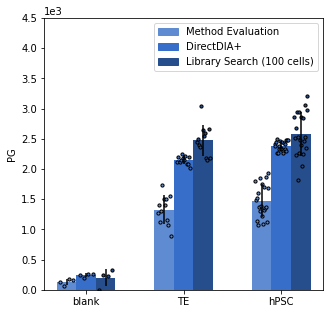

In [19]:
fig, ax = plt.subplots(1, 1 , figsize=(5 , 5))
plot_panela(ax, data)

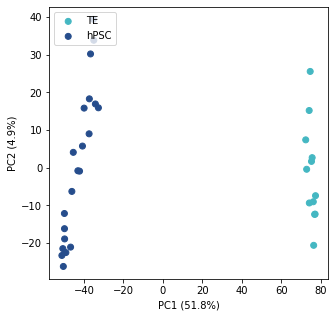

In [20]:
fig, ax = plt.subplots(1, 1 , figsize=(5 , 5))
plot_panelb(ax, data_pca_umap)

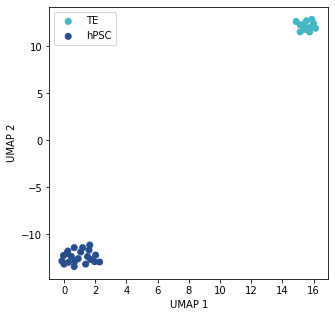

In [21]:
fig, ax = plt.subplots(1, 1 , figsize=(5 , 5))
plot_panelc(ax, data_pca_umap)